In [1]:
import pandas as pd
from collections import defaultdict
from wikidataintegrator.wdi_core import WDItemEngine
from wikidataintegrator.wdi_config import config

config['BACKOFF_MAX_TRIES'] = 1
eq = WDItemEngine.execute_sparql_query

In [2]:
ps = {'i': 'wdt:P31', 
      's': 'wdt:P279*', 
      'i_or_s': 'wdt:P31|wdt:P279*', 
      'i_path_s': 'wdt:P31/wdt:P279*', 
      's_path_i': 'wdt:P279*/wdt:P31', 
      's1_path_i': 'wdt:P279?/wdt:P31'}

query_text = """
SELECT DISTINCT ?item ?itemLabel
WHERE {{
    ?item {p} wd:{q}
    SERVICE wikibase:label {{ bd:serviceParam wikibase:language "[AUTO_LANGAGE],en" }}
}}
"""

In [3]:
import os

filename = 'disease_path_results.csv'

if os.path.exists(filename):
    res = pd.read_csv(filename)
    
else:

    results = list()

    qid = 'Q12136'
    qlabel = 'disease'

    for abbv, p in ps.items():
        r = eq(query_text.format(p=p, q=qid), as_dataframe=True)
        r['item'] = r['item'].apply(lambda s: s.split('/')[-1])
        r['p'] = abbv
        r['query_p'] = p
        results.append(r)

    res = pd.concat(results, ignore_index=True, sort=False)

In [4]:
res.sample(10)

,item,itemLabel,p,query_p
49332,Q55762664,microcephalic osteodysplastic primordial dwarfism,i_or_s,wdt:P31|wdt:P279*
14582,Q55781171,laryngeal abductor palsy,s,wdt:P279*
62678,Q758292,Atypical trigeminal neuralgia,i_or_s,wdt:P31|wdt:P279*
126283,Q55789646,benign neoplasm of rectum,s1_path_i,wdt:P279?/wdt:P31
52060,Q6650677,Little League elbow,i_or_s,wdt:P31|wdt:P279*
115009,Q18557017,MHC class II deficiency,s1_path_i,wdt:P279?/wdt:P31
50665,Q61967976,multiple congenital anomalies-hypotonia-seizur...,i_or_s,wdt:P31|wdt:P279*
20587,Q2003840,DES daughter,s,wdt:P279*
28249,Q18554643,uterine corpus epithelioid leiomyoma,s,wdt:P279*
36295,Q7611228,Stereoblindness,s,wdt:P279*


In [5]:
res['query_p'].value_counts()

wdt:P31|wdt:P279*    25699
wdt:P279*/wdt:P31    25426
wdt:P279*            24789
wdt:P279?/wdt:P31    20952
wdt:P31/wdt:P279*    17131
wdt:P31              12983
Name: query_p, dtype: int64

In [6]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

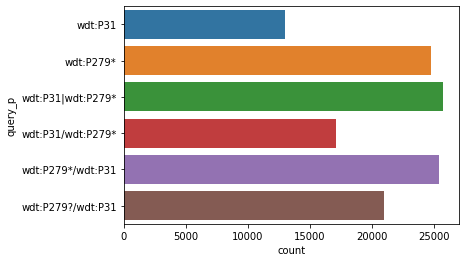

In [7]:
sns.countplot(y='query_p', data=res);

In [8]:
instance = set(res.query('p == "i"')['item'].unique())
subclass = set(res.query('p == "s"')['item'].unique())
ips = set(res.query('p == "i_path_s"')['item'].unique())
spi = set(res.query('p == "s_path_i"')['item'].unique())
s1pi = set(res.query('p == "s1_path_i"')['item'].unique())

In [9]:
item_data = {'wdt:P31': instance, 
    'wdt:P279*': subclass,
    'wdt:P31/wdt:P279*': ips, 
    'wdt:P279*/wdt:P31': spi, 
    #'wdt:P279?/wdt:P31': s1pi
            }

In [10]:
names = []
counts = []
unique_items = {}

for item in item_data.keys():
    
    all_sets = [v for k, v in item_data.items() if k != item]
    others = set.union(*all_sets)

    unique = res.query('item not in @others')
    n_unique = len(unique)
    
    names.append(item)
    counts.append(n_unique)
    unique_items[item] = res['item'].unique()
    

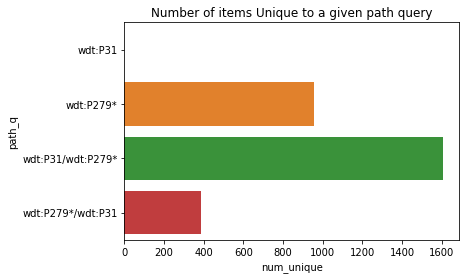

In [11]:
sns.barplot(x='num_unique', y='path_q', data=pd.DataFrame({'path_q':names, 'num_unique':counts}))
plt.title('Number of items Unique to a given path query');

In [12]:
from metapaths.tools.plot import venn2_pretty, venn3_pretty

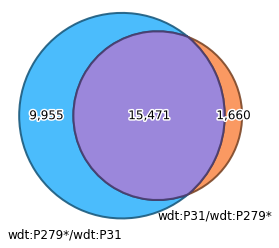

In [13]:
venn2_pretty([spi, ips], ['wdt:P279*/wdt:P31', 'wdt:P31/wdt:P279*'])

/home/mmayers/software/anaconda3/envs/ml/lib/python3.6/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


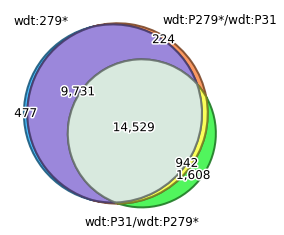

In [14]:
venn3_pretty([subclass, spi, ips], ['wdt:279*', 'wdt:P279*/wdt:P31', 'wdt:P31/wdt:P279*'])

In [15]:
qr = res.query('p == "s" and item not in @instance')

print("Subclass and not Instance: {:,}".format(len(qr)))
qr.sample(10)

Subclass and not Instance: 12,716


,item,itemLabel,p,query_p
21174,Q56026918,narcolepsy-cataplexy syndrome,s,wdt:P279*
31513,Q6079228,ischemic hepatitis,s,wdt:P279*
36555,Q48988204,Musicogenic epilepsy,s,wdt:P279*
20350,Q55785330,non-syndromic visceral malformation,s,wdt:P279*
33245,Q7371885,Rowell's syndrome,s,wdt:P279*
18416,Q22272571,chronic inflammatory response to non-antigenic...,s,wdt:P279*
14773,Q55782001,"acetylation, slow",s,wdt:P279*
19879,Q55787804,primary bone dysplasia,s,wdt:P279*
18979,Q55789631,benign neoplasm of stomach,s,wdt:P279*
32822,Q55781037,hyperkeratosis-hyperpigmentation syndrome,s,wdt:P279*


In [16]:
qr = res.query('p == "i" and item not in @subclass')

print("Instance and not Sublcass: {:,}".format(len(qr)))
qr.sample(10)

Instance and not Sublcass: 910


,item,itemLabel,p,query_p
9940,Q28873214,Aseptic osteonecrosis,i,wdt:P31
1477,Q1141055,diverticulum,i,wdt:P31
3876,Q5446465,Fibrofolliculoma,i,wdt:P31
12049,Q55784866,"intellectual disability, autosomal recessive 47",i,wdt:P31
4322,Q7205365,Plum syndrome,i,wdt:P31
5176,Q18209712,Autoimmune autonomic ganglionopathy,i,wdt:P31
1396,Q1061988,Flail chest,i,wdt:P31
5093,Q17101813,Intraparenchymal hemorrhage,i,wdt:P31
3584,Q4817543,Atrial enlargement,i,wdt:P31
3704,Q5160447,congenital melanocytic nevus,i,wdt:P31


In [17]:
qr = res.query('p == "i" and item not in @ips')

print("Instance and not P31/P279*: {:,}".format(len(qr)))

Instance and not P31/P279*: 0


In [18]:
qr = res.query('p == "i" and item not in @spi')

print("Instance and not P279*/P31: {:,}".format(len(qr)))

Instance and not P279*/P31: 0


In [19]:
qr = res.query('p == "i_path_s" and item not in @subclass')

print("P31/P279* and not Subclass: {:,}".format(len(qr)))
qr.sample(10)

P31/P279* and not Subclass: 2,550


,item,itemLabel,p,query_p
80218,Q53844623,mouse urinary tract neoplasm,i_path_s,wdt:P31/wdt:P279*
78497,Q55762942,"hypercalcemia, infantile",i_path_s,wdt:P31/wdt:P279*
63542,Q33121,serum sickness,i_path_s,wdt:P31/wdt:P279*
80381,Q7629347,stygiophobia,i_path_s,wdt:P31/wdt:P279*
80570,Q28123566,Australian pregnancy category B3,i_path_s,wdt:P31/wdt:P279*
79600,Q67247674,Q67247674,i_path_s,wdt:P31/wdt:P279*
79025,Q55950270,autosomal dominant progressive external ophtha...,i_path_s,wdt:P31/wdt:P279*
78856,Q55785075,"intellectual disability, autosomal recessive 5...",i_path_s,wdt:P31/wdt:P279*
80337,Q481041,absinthism,i_path_s,wdt:P31/wdt:P279*
71915,Q16592293,chronic subdural haematoma,i_path_s,wdt:P31/wdt:P279*


In [20]:
qr = res.query('p == "s_path_i" and item not in @subclass')

print("P279*/P31 and not Subclass:  {:,}".format(len(qr)))
qr.sample(10)

P279*/P31 and not Subclass:  1,166


,item,itemLabel,p,query_p
93002,Q56303764,Q56303764,s_path_i,wdt:P279*/wdt:P31
103985,Q19000424,pediatric soft part clear cell sarcoma,s_path_i,wdt:P279*/wdt:P31
94210,Q55278661,arterio-arterial fistula,s_path_i,wdt:P279*/wdt:P31
84691,Q5959600,Hypoestrogenism,s_path_i,wdt:P279*/wdt:P31
92536,Q55784393,"microcephaly 9, primary, autosomal recessive",s_path_i,wdt:P279*/wdt:P31
98733,Q1090174,Chvostek sign,s_path_i,wdt:P279*/wdt:P31
85423,Q16123797,Q16123797,s_path_i,wdt:P279*/wdt:P31
93510,Q67247674,Q67247674,s_path_i,wdt:P279*/wdt:P31
82943,Q2311755,splenosis,s_path_i,wdt:P279*/wdt:P31
94563,Q55782875,secondary nocturnal enuresis,s_path_i,wdt:P279*/wdt:P31


In [21]:
qr = res.query('p == "i_path_s" and item not in @instance')

print("P31/P279* and not Instance: {:,}".format(len(qr)))
qr.sample(10)

P31/P279* and not Instance: 4,148


,item,itemLabel,p,query_p
70538,Q55787130,"brachydactyly of toes, unilateral",i_path_s,wdt:P31/wdt:P279*
69152,Q5441913,feline hyperaldosteronism,i_path_s,wdt:P31/wdt:P279*
71422,Q55789144,cystic malformation of the posterior fossa,i_path_s,wdt:P31/wdt:P279*
65319,Q3508622,Bickerstaff's encephalitis,i_path_s,wdt:P31/wdt:P279*
80344,Q5958573,Hypersexual disorder,i_path_s,wdt:P31/wdt:P279*
79721,Q595708,Equine exertional rhabdomyolysis,i_path_s,wdt:P31/wdt:P279*
67644,Q55781385,polydactyly-myopia syndrome,i_path_s,wdt:P31/wdt:P279*
68991,Q55785562,congenital nasal pyriform aperture stenosis wi...,i_path_s,wdt:P31/wdt:P279*
79814,Q24284107,Renal dysplasia,i_path_s,wdt:P31/wdt:P279*
72412,Q1818335,nosemosis,i_path_s,wdt:P31/wdt:P279*


In [22]:
qr = res.query('p == "i_path_s" and item not in @instance and item not in @subclass')

print("P31/P279* and not Instance or Sublcass: {:,}".format(len(qr)))
qr.sample(10)

P31/P279* and not Instance or Sublcass: 1,640


,item,itemLabel,p,query_p
69260,Q55785913,congenital aortopulmonary window,i_path_s,wdt:P31/wdt:P279*
79956,Q1679678,hydrops fetalis,i_path_s,wdt:P31/wdt:P279*
69840,Q53643192,rabbit oral cavity squamous cell carcinoma,i_path_s,wdt:P31/wdt:P279*
69638,Q55786588,partial deletion of the short arm of chromosome 2,i_path_s,wdt:P31/wdt:P279*
71374,Q55788993,maternal uniparental disomy of chromosome 21,i_path_s,wdt:P31/wdt:P279*
78977,Q53615329,chicken fibrosarcoma,i_path_s,wdt:P31/wdt:P279*
70743,Q53701110,canine rhabdomyosarcoma,i_path_s,wdt:P31/wdt:P279*
80087,Q7440546,Seal finger,i_path_s,wdt:P31/wdt:P279*
73797,Q55789565,carcinoma in situ of nasopharynx,i_path_s,wdt:P31/wdt:P279*
76051,Q53703749,hamster fibrosarcoma,i_path_s,wdt:P31/wdt:P279*


In [23]:
qr = res.query('p == "s_path_i" and item not in @instance')

print("P279*/P31 and not Instance: {:,}".format(len(qr)))
qr.sample(10)

P279*/P31 and not Instance: 12,443


,item,itemLabel,p,query_p
104532,Q18966324,Mumps virus encephalitis,s_path_i,wdt:P279*/wdt:P31
99507,Q129279,dysentery,s_path_i,wdt:P279*/wdt:P31
103774,Q56014355,rare renal tumor,s_path_i,wdt:P279*/wdt:P31
104544,Q18975513,peste des petits ruminants infectious disease,s_path_i,wdt:P279*/wdt:P31
97148,Q55788257,idiopathic neonatal atrial flutter,s_path_i,wdt:P279*/wdt:P31
100803,Q74528,Rabbit syndrome,s_path_i,wdt:P279*/wdt:P31
105999,Q2361468,pseudohallucination,s_path_i,wdt:P279*/wdt:P31
96678,Q18616429,avian aspergillosis,s_path_i,wdt:P279*/wdt:P31
95522,Q18928386,Rubella virus hepatitis,s_path_i,wdt:P279*/wdt:P31
104100,Q21110098,decreased audio-visual performance,s_path_i,wdt:P279*/wdt:P31


In [24]:
qr = res.query('p == "s_path_i" and item not in @subclass')

print("P279*/P31 and not Subclass: {:,}".format(len(qr)))
qr.sample(10)

P279*/P31 and not Subclass: 1,166


,item,itemLabel,p,query_p
95544,Q62391220,suicide by asphyxiation,s_path_i,wdt:P279*/wdt:P31
94195,Q41795609,Esophageal Fistula,s_path_i,wdt:P279*/wdt:P31
81057,Q281490,urinary incontinence,s_path_i,wdt:P279*/wdt:P31
92027,Q55093051,artificial lens implant migration,s_path_i,wdt:P279*/wdt:P31
103138,Q945225,ventricular hypertrophy,s_path_i,wdt:P279*/wdt:P31
105889,Q55789028,drug-related renal tubular dysgenesis,s_path_i,wdt:P279*/wdt:P31
91830,Q54931551,nervous system paraneoplastic syndrome,s_path_i,wdt:P279*/wdt:P31
92769,Q55785090,"epileptic encephalopathy, early infantile, 40;...",s_path_i,wdt:P279*/wdt:P31
104475,Q16553594,breakthrough seizure,s_path_i,wdt:P279*/wdt:P31
98717,Q55788976,ring chromosome 2,s_path_i,wdt:P279*/wdt:P31


In [25]:
qr = res.query('p == "s_path_i" and item not in @subclass and item not in @instance')

print("P279*/P31 and not Subclass or Instahce: {:,}".format(len(qr)))
qr.sample(10)

P279*/P31 and not Subclass or Instahce: 256


,item,itemLabel,p,query_p
93880,Q7852677,Tumor hypoxia,s_path_i,wdt:P279*/wdt:P31
105901,Q4470771,centipede bite,s_path_i,wdt:P279*/wdt:P31
105535,Q5693263,Heat cramps,s_path_i,wdt:P279*/wdt:P31
106024,Q55782434,"mycobacterium tuberculosis, susceptibility to,...",s_path_i,wdt:P279*/wdt:P31
94084,Q3797702,Stress incontinence,s_path_i,wdt:P279*/wdt:P31
98775,Q55790289,giant mammary hamartoma,s_path_i,wdt:P279*/wdt:P31
106011,Q55789091,gonosome number anomaly,s_path_i,wdt:P279*/wdt:P31
99481,Q19000645,anaplastic ependymoma,s_path_i,wdt:P279*/wdt:P31
105675,Q55999491,"alopecia, congenital",s_path_i,wdt:P279*/wdt:P31
96898,Q7835823,traumatic asphyxia,s_path_i,wdt:P279*/wdt:P31


In [26]:
qr = res.query('p == "s_path_i" and item not in @ips')

print("P279*/P31 and not P31/P279*: {:,}".format(len(qr)))
qr.sample(10)

P279*/P31 and not P31/P279*: 9,955


,item,itemLabel,p,query_p
98419,Q55787313,disorder of sialic acid metabolism,s_path_i,wdt:P279*/wdt:P31
103815,Q19001283,carcinoma in situ of male genital organs,s_path_i,wdt:P279*/wdt:P31
99949,Q3842207,maculopathy,s_path_i,wdt:P279*/wdt:P31
100540,Q201672,Trendelenburg's sign,s_path_i,wdt:P279*/wdt:P31
95319,Q56218018,Heart failure with reduced ejection fraction,s_path_i,wdt:P279*/wdt:P31
105146,Q19001137,carcinoma in situ of breast and genitourinary ...,s_path_i,wdt:P279*/wdt:P31
96023,Q55789079,internal carotid agenesis,s_path_i,wdt:P279*/wdt:P31
95335,Q2870714,organic anxiety disorder,s_path_i,wdt:P279*/wdt:P31
99674,Q55788844,AFib amyloidosis,s_path_i,wdt:P279*/wdt:P31
99021,Q55785519,rare genetic hepatic disease,s_path_i,wdt:P279*/wdt:P31


In [27]:
qr = res.query('p == "i_path_s" and item not in @spi')

print("P31/P279* and not P279*/P31: {:,}".format(len(qr)))
qr.sample(10)

P31/P279* and not P279*/P31: 1,660


,item,itemLabel,p,query_p
69131,Q5317900,Dwarf cat,i_path_s,wdt:P31/wdt:P279*
79907,Q17115915,Black pod disease,i_path_s,wdt:P31/wdt:P279*
70355,Q479065,equine sarcoid,i_path_s,wdt:P31/wdt:P279*
70877,Q55788781,Pfeiffer syndrome type 1,i_path_s,wdt:P31/wdt:P279*
78924,Q1922421,mesiodens,i_path_s,wdt:P31/wdt:P279*
80426,Q63366227,Q63366227,i_path_s,wdt:P31/wdt:P279*
65542,Q63871268,Extensive spinal canal stenosis,i_path_s,wdt:P31/wdt:P279*
75616,Q12856836,Sirococcus Shoot Blight,i_path_s,wdt:P31/wdt:P279*
69194,Q55785675,mosaic trisomy 14,i_path_s,wdt:P31/wdt:P279*
79701,Q2092492,clinical vampirism,i_path_s,wdt:P31/wdt:P279*


In [28]:
qr = res.query('p == "i_path_s" and item not in @s1pi')

print("P31/P279* and not P279*/P31: {:,}".format(len(qr)))
qr.sample(10)

P31/P279* and not P279*/P31: 3,034


,item,itemLabel,p,query_p
70550,Q55787552,hearing loss-familial salivary gland insensiti...,i_path_s,wdt:P31/wdt:P279*
71672,Q55790104,craniosynostosis arthrogryposis cleft palate,i_path_s,wdt:P31/wdt:P279*
80495,Q17084483,puppy pregnancy syndrome,i_path_s,wdt:P31/wdt:P279*
71642,Q2914153,amotivational syndrome,i_path_s,wdt:P31/wdt:P279*
76280,Q53845064,mouse lymphoma,i_path_s,wdt:P31/wdt:P279*
69999,Q55786818,isolated cerebellar vermis agenesis,i_path_s,wdt:P31/wdt:P279*
69837,Q53613704,walleye dermal sarcoma,i_path_s,wdt:P31/wdt:P279*
75619,Q7808080,tinea incognito,i_path_s,wdt:P31/wdt:P279*
68990,Q55785469,"lethal chondrodysplasia, Moerman type",i_path_s,wdt:P31/wdt:P279*
71408,Q55788994,maternal uniparental disomy of chromosome 22,i_path_s,wdt:P31/wdt:P279*


In [29]:
qr = res.query('p == "s1_path_i" and item not in @ips')

print("P279?/P31 and not P31/P279*: {:,}".format(len(qr)))
qr.sample(10)

P279?/P31 and not P31/P279*: 6,855


,item,itemLabel,p,query_p
117312,Q55789826,Basaran Yilmaz syndrome,s1_path_i,wdt:P279?/wdt:P31
126692,Q19001374,vitreous membranes and strands,s1_path_i,wdt:P279?/wdt:P31
116435,Q16910501,Hypokalemic acidosis,s1_path_i,wdt:P279?/wdt:P31
126677,Q55786097,undifferentiated carcinoma of the corpus uteri,s1_path_i,wdt:P279?/wdt:P31
107455,Q1641128,Hypertelorism,s1_path_i,wdt:P279?/wdt:P31
121906,Q4782756,Aquarium granuloma,s1_path_i,wdt:P279?/wdt:P31
123014,Q7104928,Orthostatic purpura,s1_path_i,wdt:P279?/wdt:P31
125771,Q55788126,rare autonomic nervous system disorder,s1_path_i,wdt:P279?/wdt:P31
126358,Q7674677,Tadpole pupil,s1_path_i,wdt:P279?/wdt:P31
119048,Q2106293,Overwhelming post-splenectomy infection,s1_path_i,wdt:P279?/wdt:P31


In [30]:
qr = res.query('p == "s_path_i" and item not in @s1pi')

print("P279*/P31 and not P279?/P31: {:,}".format(len(qr)))
qr.sample(10)

P279*/P31 and not P279?/P31: 4,474


,item,itemLabel,p,query_p
100817,Q55786049,qualitative or quantitative defects of glucosa...,s_path_i,wdt:P279*/wdt:P31
99591,Q3533214,Oropharyngeal dysphagia,s_path_i,wdt:P279*/wdt:P31
97340,Q55789701,benign neoplasm of brain stem,s_path_i,wdt:P279*/wdt:P31
98188,Q55790455,patent ductus arteriosus 3,s_path_i,wdt:P279*/wdt:P31
105980,Q3458171,penis-shrinker,s_path_i,wdt:P279*/wdt:P31
96547,Q56014092,isolated brachycephaly,s_path_i,wdt:P279*/wdt:P31
102151,Q55786724,partial duplication of the long arm of chromos...,s_path_i,wdt:P279*/wdt:P31
105931,Q4763844,Angor animi,s_path_i,wdt:P279*/wdt:P31
96403,Q55780409,cataract-aberrant oral frenula-growth delay sy...,s_path_i,wdt:P279*/wdt:P31
103279,Q55787626,"46,XX disorder of sex development induced by e...",s_path_i,wdt:P279*/wdt:P31


In [31]:
res.query('p == "s_path_i" or p == "i_path_s"')['item'].nunique()

27086

In [32]:
res.to_csv(filename, index=False)